# Imports 

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from dictionary import column_mapping
import textwrap

sns.set_theme()

# 4. Modelling

In [25]:
df = pd.read_csv("../../../databases/q3_database.csv")
df = df.drop(columns=["Avg Reading Result"])
df.sample(5)

,Avg Math Result,BFMJ2,BMMJ1,CNT_Group,CREATOOS,ESCS,FAMCON,HISEI,HOMEPOS,IC171Q02JA,...,ST289Q02JA,ST289Q05WA,ST289Q06JA,ST289Q10WA,ST290Q01WA,ST290Q02WA,ST290Q03WA,ST290Q05WA,ST291Q01JA,ST355Q02JA
167512,510.8438,37.83,76.65,Above Average,0.8223,0.9074,0.0026,76.65,0.3967,5.0,...,NaN,NaN,3.0,3.0,2.0,NaN,NaN,NaN,2.0,NaN
405363,412.3342,26.62,21.24,Below Average,NaN,-2.7477,NaN,26.62,-2.0070,NaN,...,NaN,NaN,NaN,NaN,2.0,1.0,1.0,1.0,NaN,NaN
483511,529.6843,29.16,68.70,Above Average,-0.8105,0.8194,0.5353,68.70,0.5433,4.0,...,5.0,4.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0
238529,333.8994,39.04,17.00,Below Average,1.2528,-1.9362,NaN,39.04,-1.8434,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,3.0
15037,381.3510,43.33,66.42,Below Average,-0.8105,0.3818,-1.2191,66.42,-0.3882,2.0,...,2.0,NaN,2.0,NaN,1.0,2.0,NaN,3.0,NaN,NaN


In [26]:
y = df["Avg Math Result"]
X = df.drop(columns=["Avg Math Result"])

# repeat_col = X["REPEAT"]
# X = X.drop(columns=["REPEAT"])

vocational_col = X["ISCEDP"]
X = X.drop(columns=["ISCEDP"])

### Pre-process

In [27]:
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns

categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

numerical_transformer = Pipeline(
    [("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    [
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

X_encoded = preprocessor.fit_transform(X)

onehot_columns = preprocessor.named_transformers_["cat"][
    "onehot"
].get_feature_names_out(categorical_cols)
final_columns = list(numerical_cols) + list(onehot_columns)


X_encoded_df = pd.DataFrame(X_encoded, columns=final_columns)

X_encoded_df["ISCEDP"] = vocational_col.reset_index(drop=True)

X_encoded_vocational = X_encoded_df[X_encoded_df["ISCEDP"].isin([254, 354, 453])].drop(columns=["ISCEDP"])
X_encoded_non_vocational = X_encoded_df[X_encoded_df["ISCEDP"].isin([244, 341, 343, 344])].drop(
    columns=["ISCEDP"]
)

### K-means

In [28]:
kmeans_vocational = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X_encoded_vocational)
kmeans_non_vocational = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X_encoded_non_vocational)

In [29]:
vocational = df[df["ISCEDP"].isin([254, 354, 453])].reset_index(drop=True)
vocational["kmeans"] = kmeans_vocational.labels_
X_encoded_vocational["kmeans"] = kmeans_vocational.labels_

non_vocational = df[df["ISCEDP"].isin([244, 341, 343, 344])].reset_index(drop=True)
non_vocational["kmeans"] = kmeans_non_vocational.labels_
X_encoded_non_vocational["kmeans"] = kmeans_non_vocational.labels_

print(vocational.groupby("kmeans")["Avg Math Result"].describe().to_string())
print(non_vocational.groupby("kmeans")["Avg Math Result"].describe().to_string())

          count        mean        std       min         25%        50%        75%       max
kmeans                                                                                      
0       16560.0  388.905439  63.887531  188.6989  342.710625  384.74165  430.89345  663.7364
1       34253.0  452.327631  83.398483  187.3534  390.856100  449.73390  510.86170  749.7420
2       24847.0  372.900020  64.640399  153.0222  327.173250  365.97840  412.27515  706.7947
           count        mean        std       min         25%        50%         75%       max
kmeans                                                                                        
0       184430.0  523.023809  85.822250  161.1425  465.982525  525.53585  581.947325  843.2881
1       237640.0  426.929260  78.106166   97.6254  370.236275  423.03815  478.822525  779.5485
2       116010.0  357.572096  63.599781   39.1713  313.699300  350.53505  394.142075  731.8642


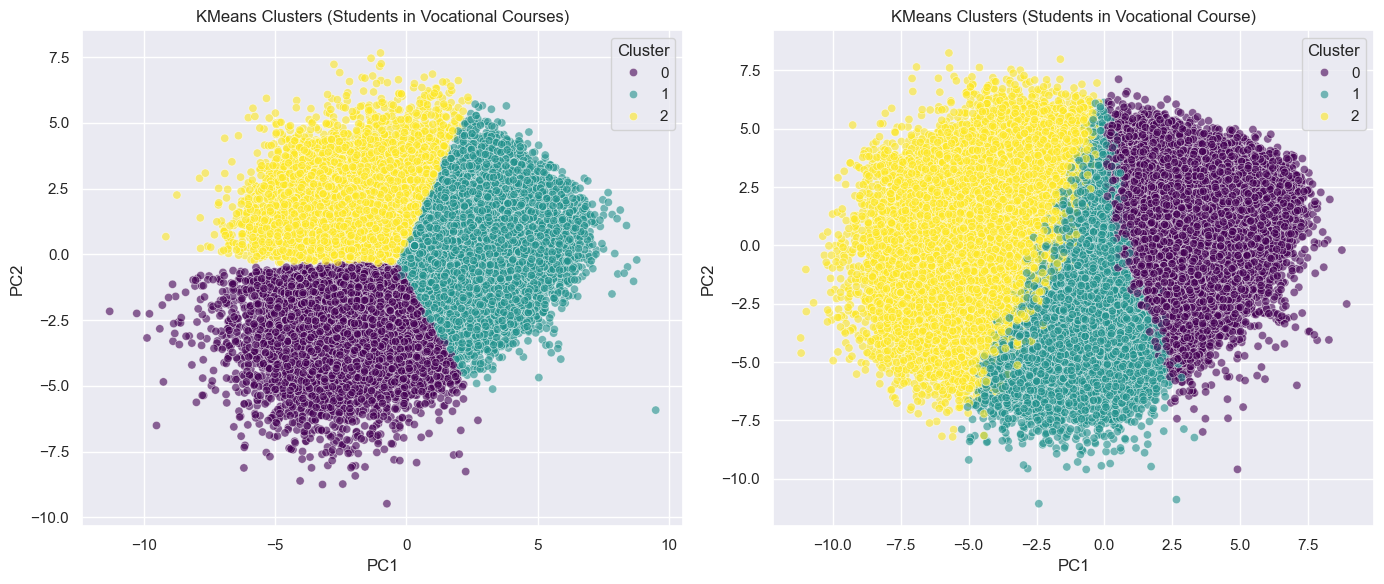

In [30]:
# vocational pca
pca_vocational = PCA(n_components=2)
X_pca_vocational = pca_vocational.fit_transform(X_encoded_vocational)
X_pca_vocational_df = pd.DataFrame(X_pca_vocational, columns=["PC1", "PC2"])
X_pca_vocational_df["Cluster"] = kmeans_vocational.labels_

# non vocational pca
pca_non_vocational = PCA(n_components=2)
X_pca_non_vocational = pca_non_vocational.fit_transform(X_encoded_non_vocational)
X_pca_non_vocational_df = pd.DataFrame(X_pca_non_vocational, columns=["PC1", "PC2"])
X_pca_non_vocational_df["Cluster"] = kmeans_non_vocational.labels_

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(
    data=X_pca_vocational_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_title("KMeans Clusters (Students in Vocational Courses)")

sns.scatterplot(
    data=X_pca_non_vocational_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_title("KMeans Clusters (Students in Vocational Course)")
plt.tight_layout()
plt.show()

Ordenar os rótulos por média:

In [31]:
means = vocational.groupby("kmeans")["Avg Math Result"].mean()
ordered_labels = means.sort_values().index.tolist()

label_map = {old_label: new_label for new_label, old_label in enumerate(ordered_labels)}

vocational["kmeans"] = vocational["kmeans"].map(label_map)
X_encoded_vocational["kmeans"] = X_encoded_vocational["kmeans"].map(label_map)

means_nonvocational = non_vocational.groupby("kmeans")["Avg Math Result"].mean()
ordered_labels_nonvocational = means_nonvocational.sort_values().index.tolist()
label_map_nonvocational = {
    old_label: new_label for new_label, old_label in enumerate(ordered_labels_nonvocational)
}
non_vocational["kmeans"] = non_vocational["kmeans"].map(label_map_nonvocational)
X_encoded_non_vocational["kmeans"] = X_encoded_non_vocational["kmeans"].map(
    label_map_nonvocational
)

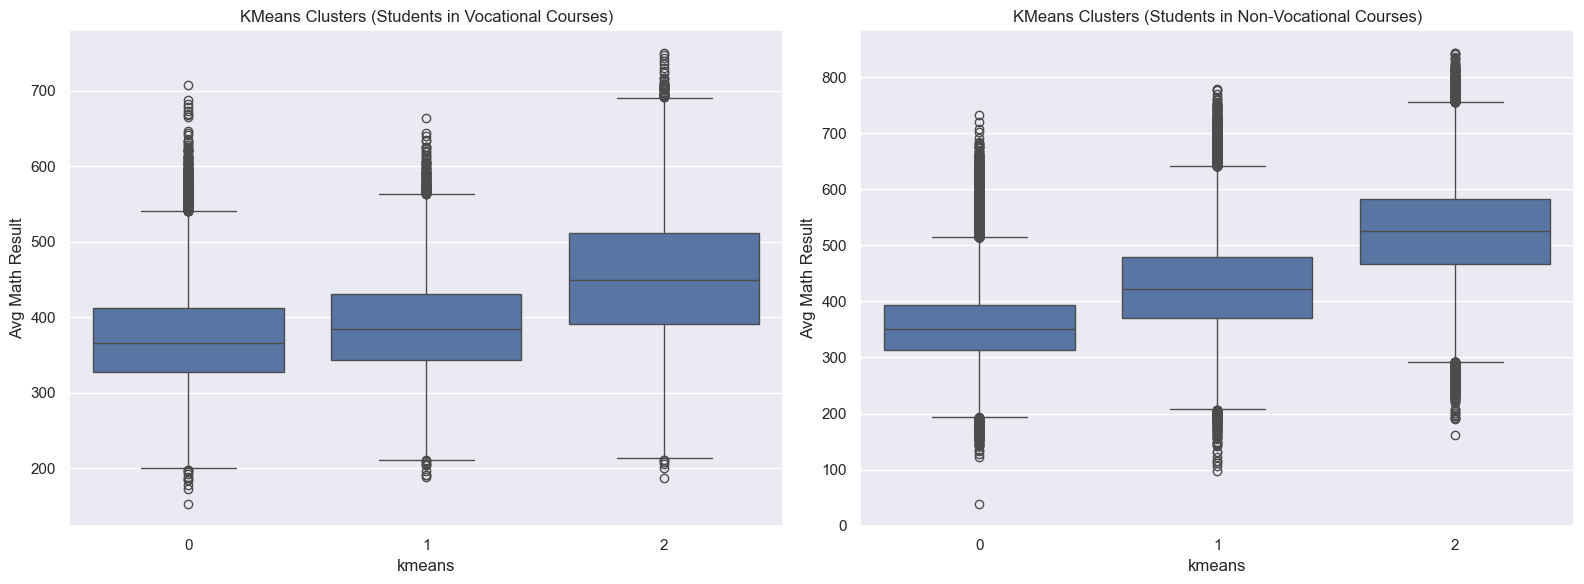

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(
    data=vocational,
    x="kmeans",
    y="Avg Math Result",
    ax=axes[0],
)
axes[0].set_title("KMeans Clusters (Students in Vocational Courses)")

sns.boxplot(
    data=non_vocational,
    x="kmeans",
    y="Avg Math Result",
    ax=axes[1],
)
axes[1].set_title("KMeans Clusters (Students in Non-Vocational Courses)")

plt.tight_layout()
plt.show()

TODO: Avaliar quais destes gráficos podem ser interessantes para mostrar

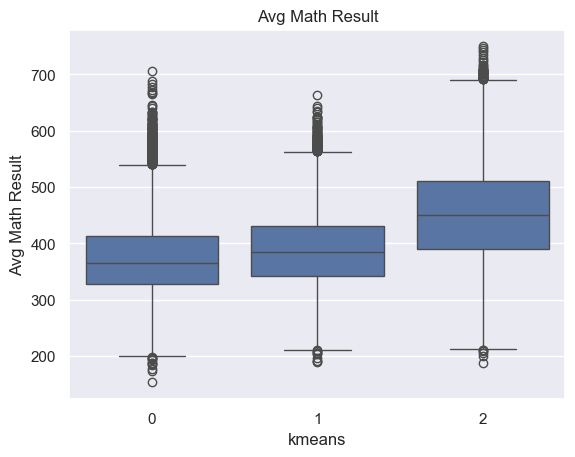

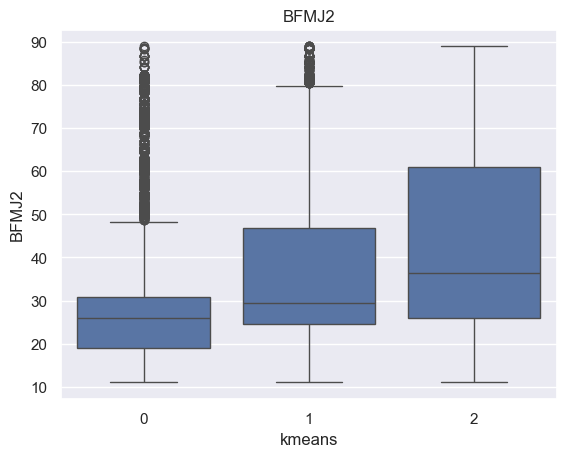

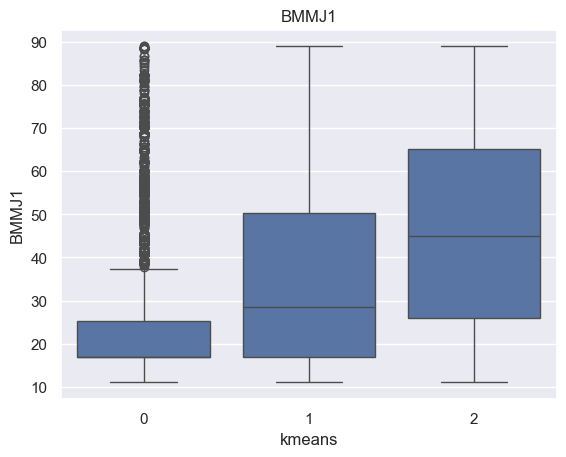

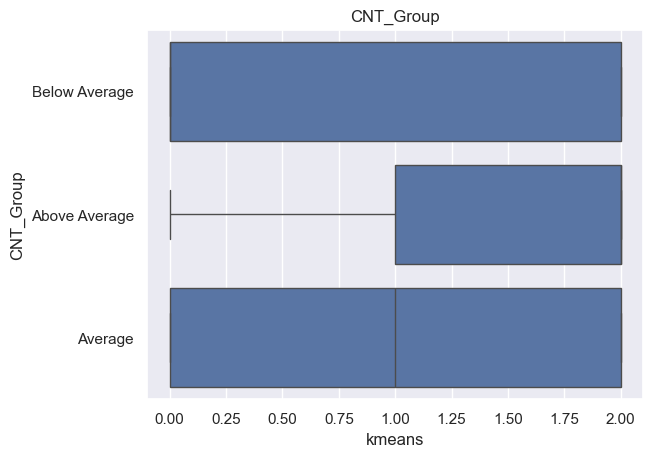

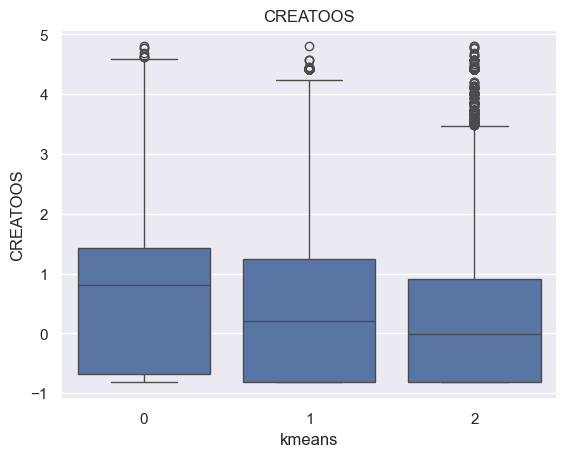

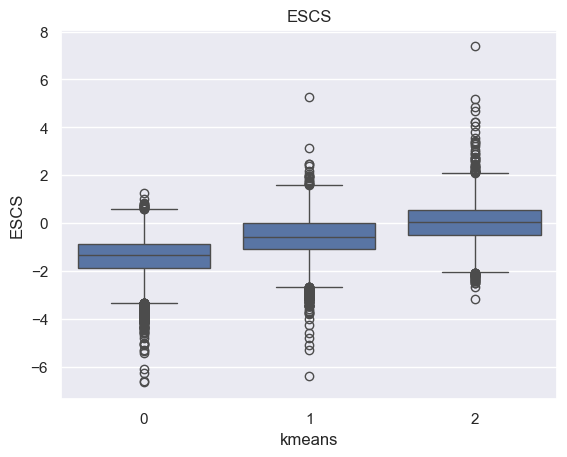

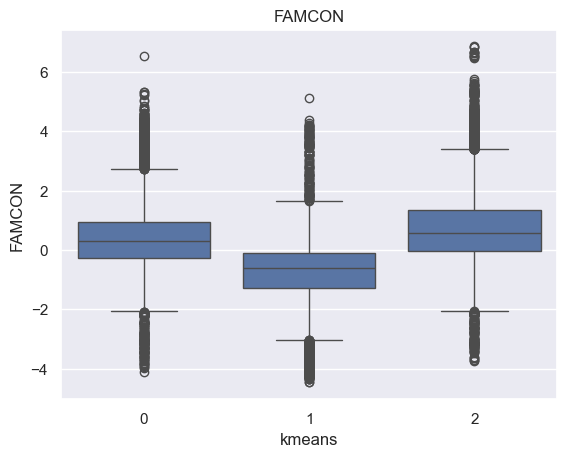

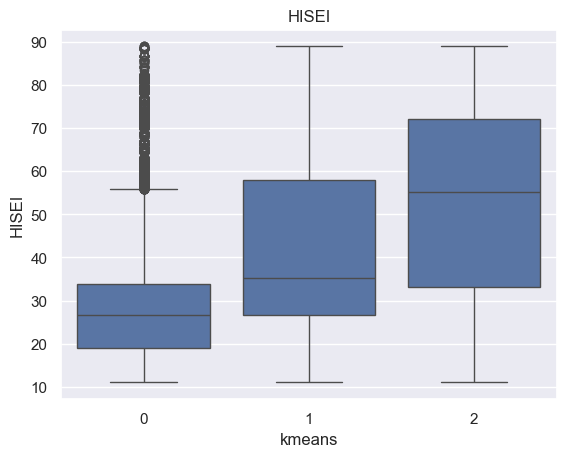

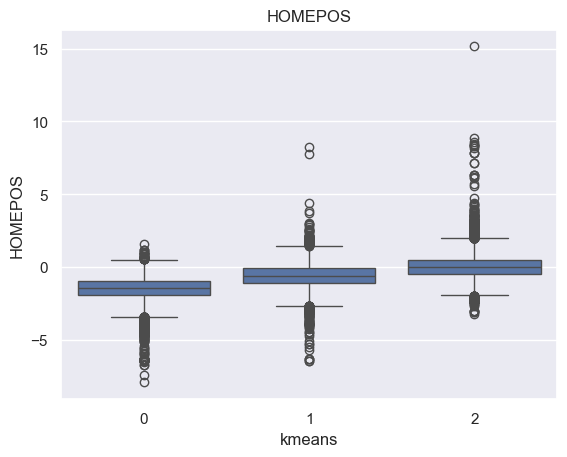

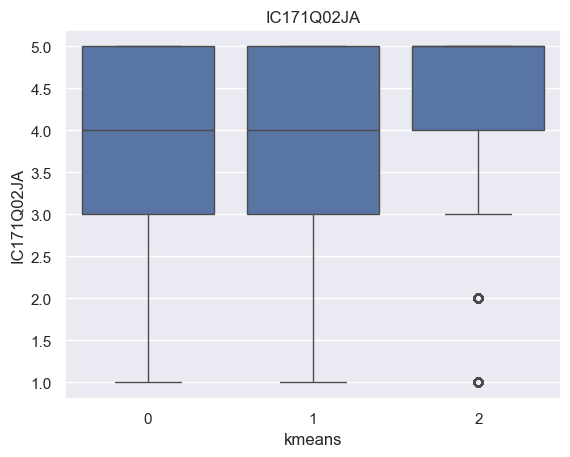

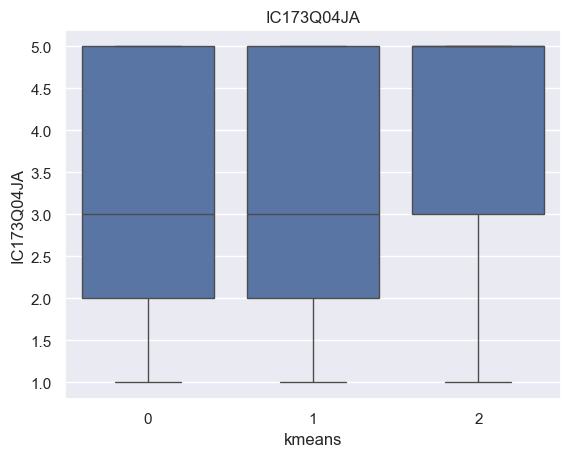

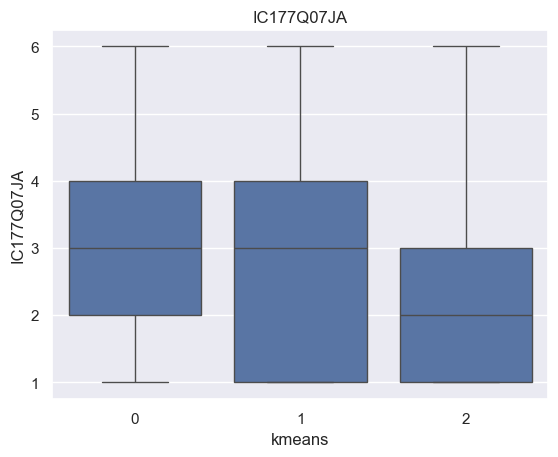

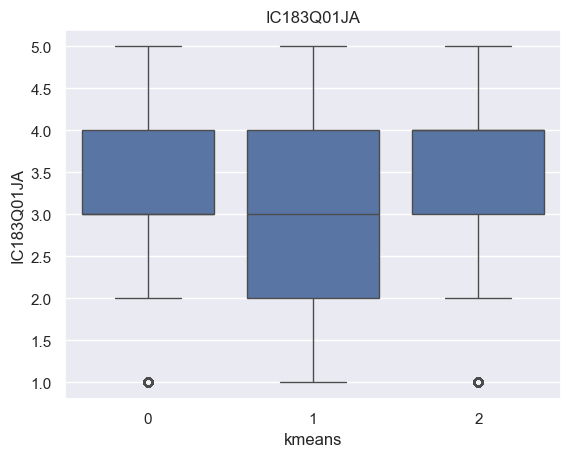

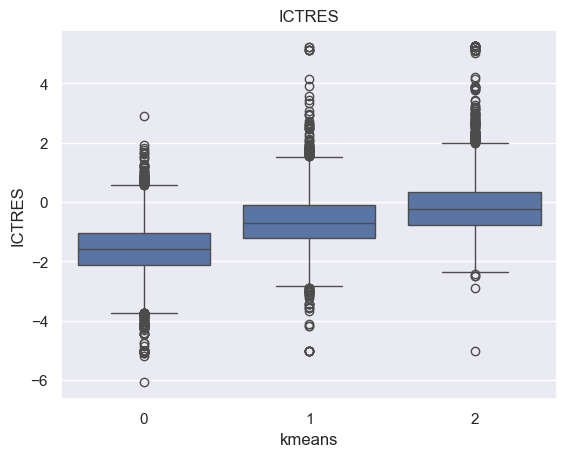

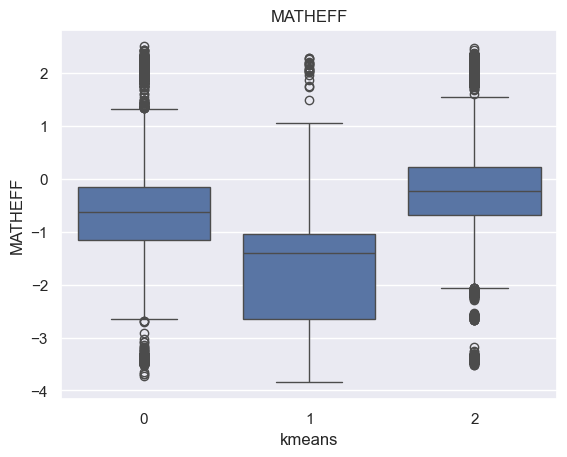

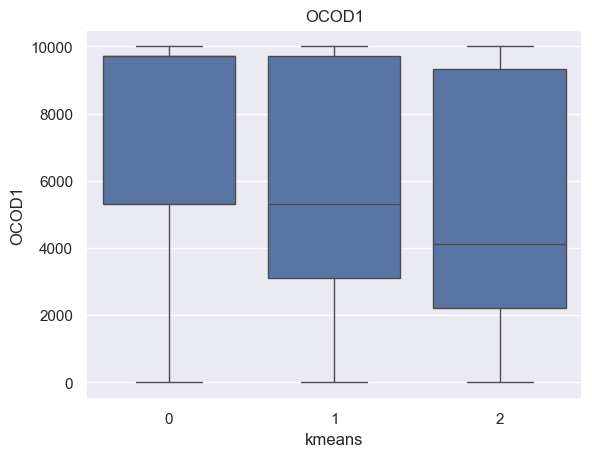

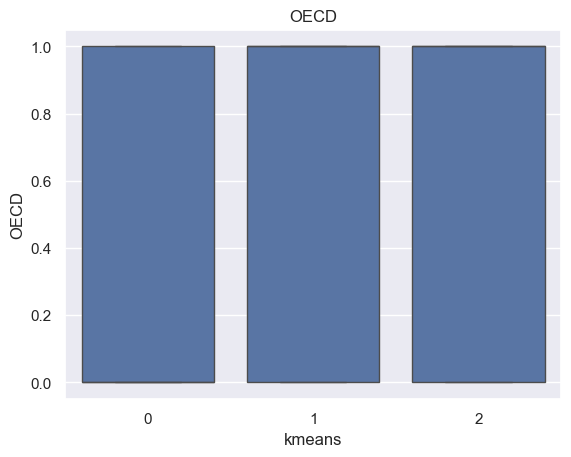

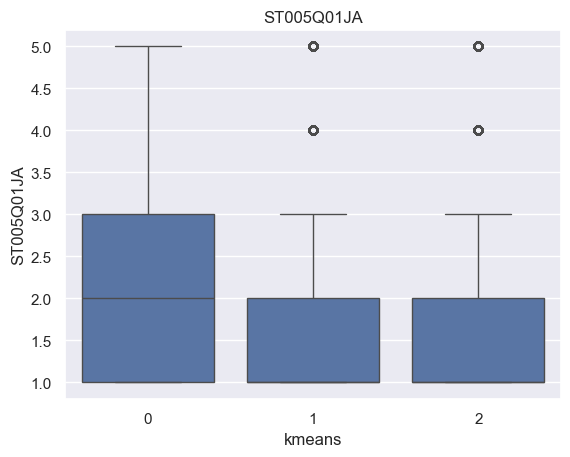

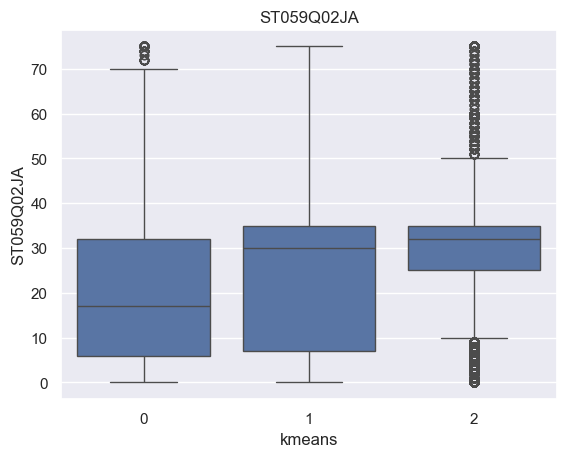

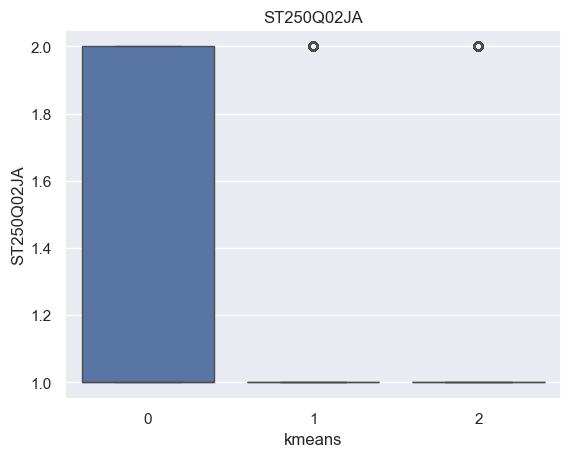

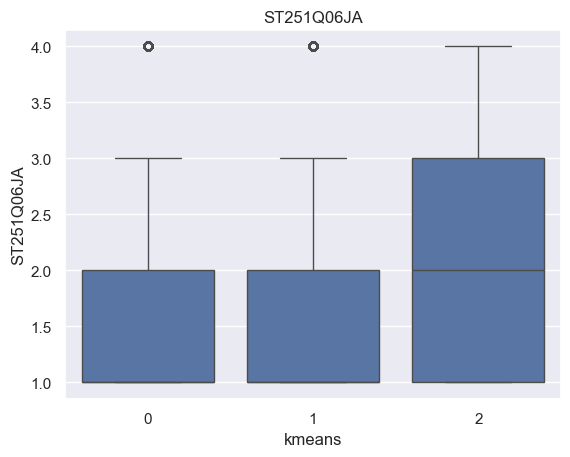

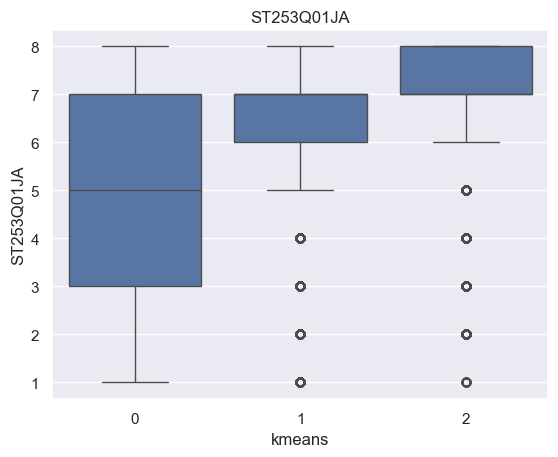

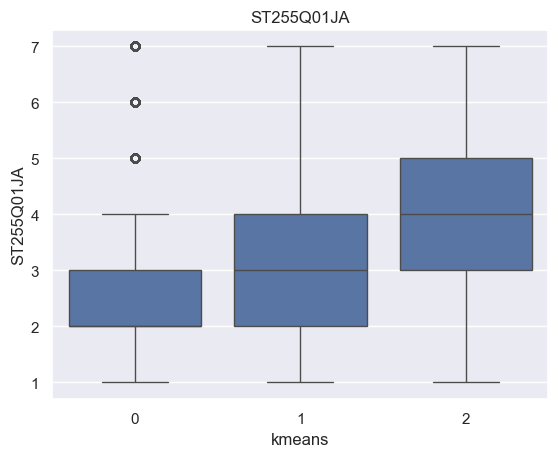

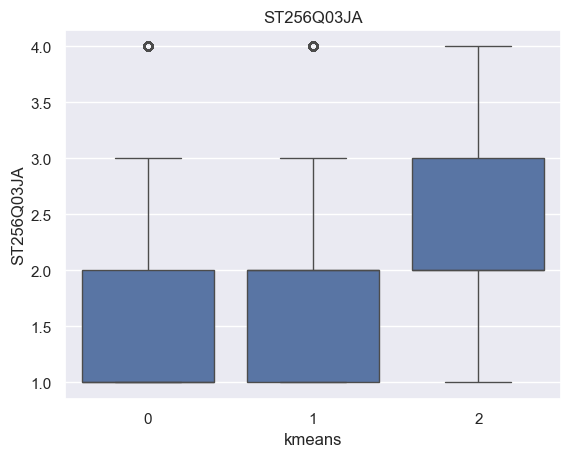

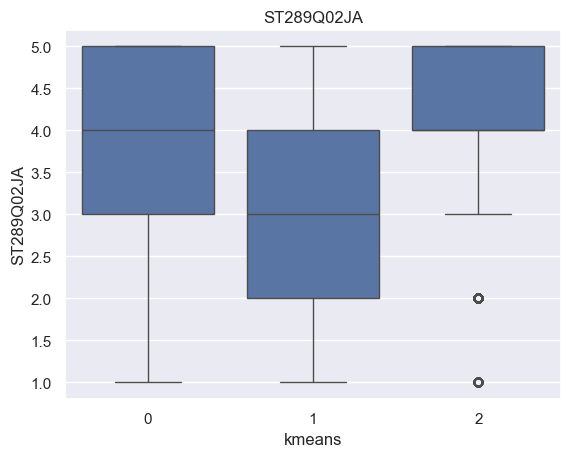

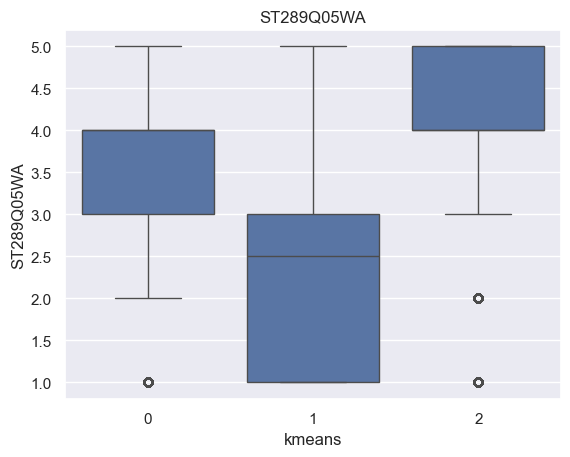

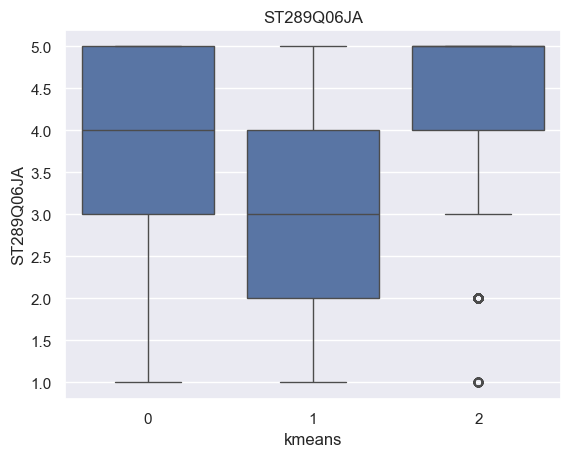

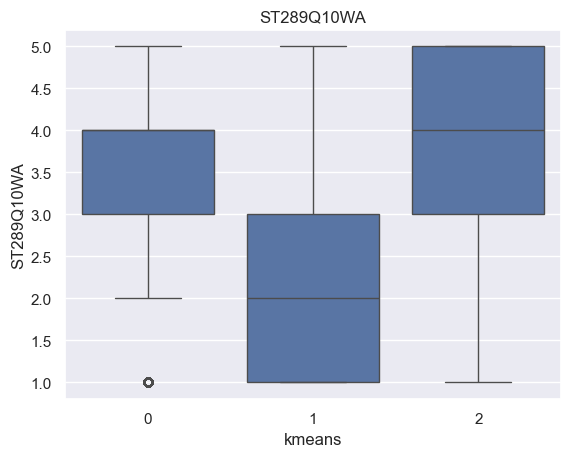

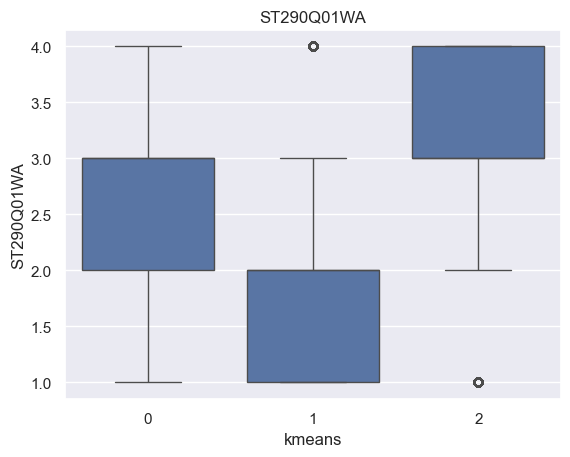

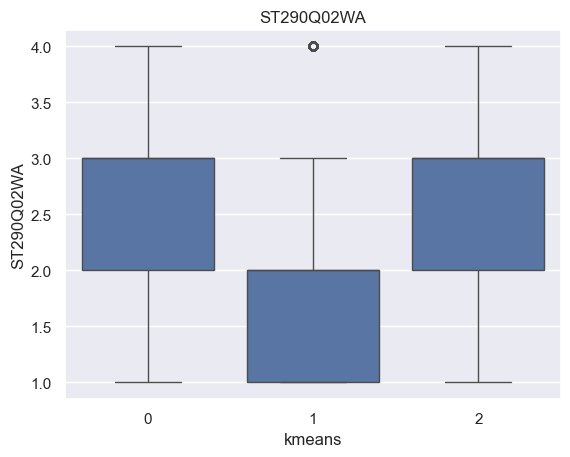

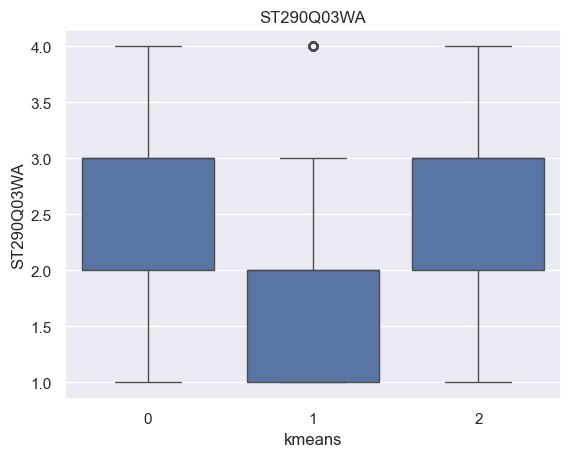

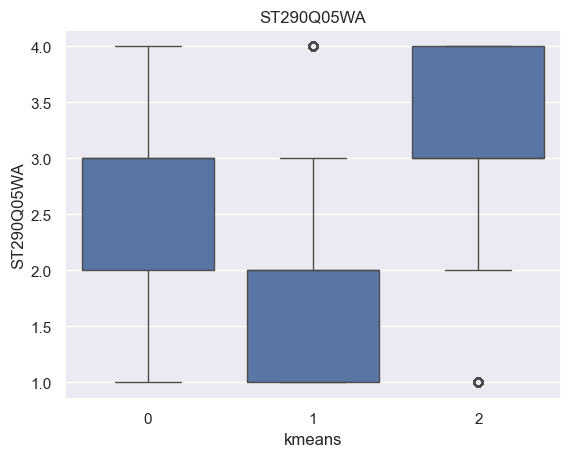

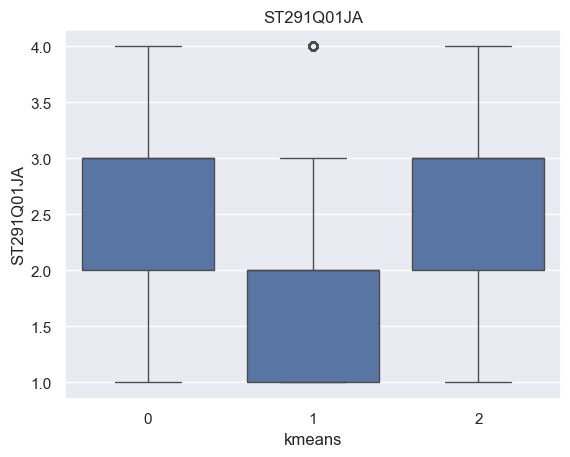

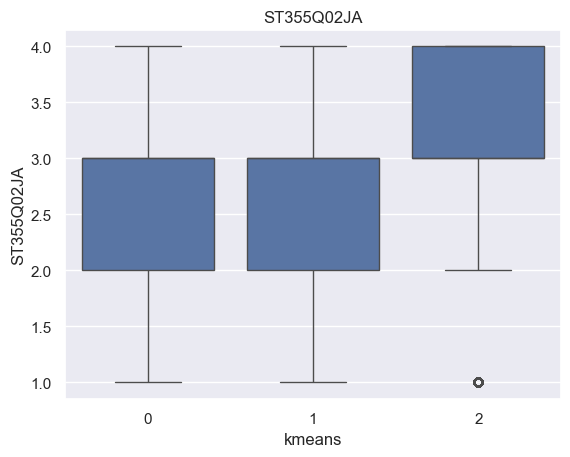

In [33]:
columns_to_plot = vocational.columns.drop(["kmeans", "REPEAT", "ISCEDP"])
for column in columns_to_plot:
    sns.boxplot(data=vocational, x="kmeans", y=column)
    plt.title(column)
    plt.show()

In [34]:
centroids_vocational = pd.DataFrame(
    kmeans_vocational.cluster_centers_,
    columns=X_encoded_vocational.drop(columns="kmeans").columns,
)
print(centroids_vocational.to_string())

      BFMJ2     BMMJ1  CREATOOS      ESCS    FAMCON     HISEI   HOMEPOS  IC171Q02JA  IC173Q04JA  IC177Q07JA  IC183Q01JA    ICTRES   MATHEFF     OCOD1      OECD    REPEAT  ST005Q01JA  ST059Q02JA  ST250Q02JA  ST251Q06JA  ST253Q01JA  ST255Q01JA  ST256Q03JA  ST289Q02JA  ST289Q05WA  ST289Q06JA  ST289Q10WA  ST290Q01WA  ST290Q02WA  ST290Q03WA  ST290Q05WA  ST291Q01JA  ST355Q02JA  CNT_Group_Above Average  CNT_Group_Average  CNT_Group_Below Average
0 -0.300053 -0.244807  0.028431 -0.204560 -1.045029 -0.308334 -0.107937   -0.399552   -0.242002    0.270323   -0.539708 -0.028217 -1.209897  0.085943  0.053361 -0.047014   -0.053305   -0.117483   -0.170366   -0.240855    0.018207   -0.291347   -0.248677   -0.856442   -0.757907   -0.762141   -0.774047   -0.812053   -0.789623   -0.840120   -0.918101   -0.838006   -0.332079                 0.488202           0.180496                 0.331302
1 -0.021462  0.119181 -0.064743  0.288346  0.239100  0.114870  0.406896    0.164091    0.243930    0.064136    0.1

In [35]:
def plot_feature_importances(importance_df, cluster_id=None, mapping=column_mapping):
    melted_df = importance_df.reset_index().melt(
        id_vars="index", var_name="Group", value_name="Importance"
    )
    melted_df.rename(columns={"index": "Feature"}, inplace=True)

    melted_df["Feature"] = (
        melted_df["Feature"]
        .map(mapping)
        .fillna(melted_df["Feature"])
        .apply(lambda x: "\n".join(textwrap.wrap(x, 60)))
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(data=melted_df, y="Feature", x="Importance", hue="Group")
    if cluster_id is not None:
        plt.title(
            f"Top Feature Importances for Cluster {cluster_id} (Vocational vs Non-Vocational)"
        )
    else:
        plt.title(
            f"Top Feature Importances (Vocational vs Non-Vocational)"
        )
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.legend(title="Group")
    plt.tight_layout()
    plt.show()

## Supervised Learning Aproach (Random Forest Classifier)

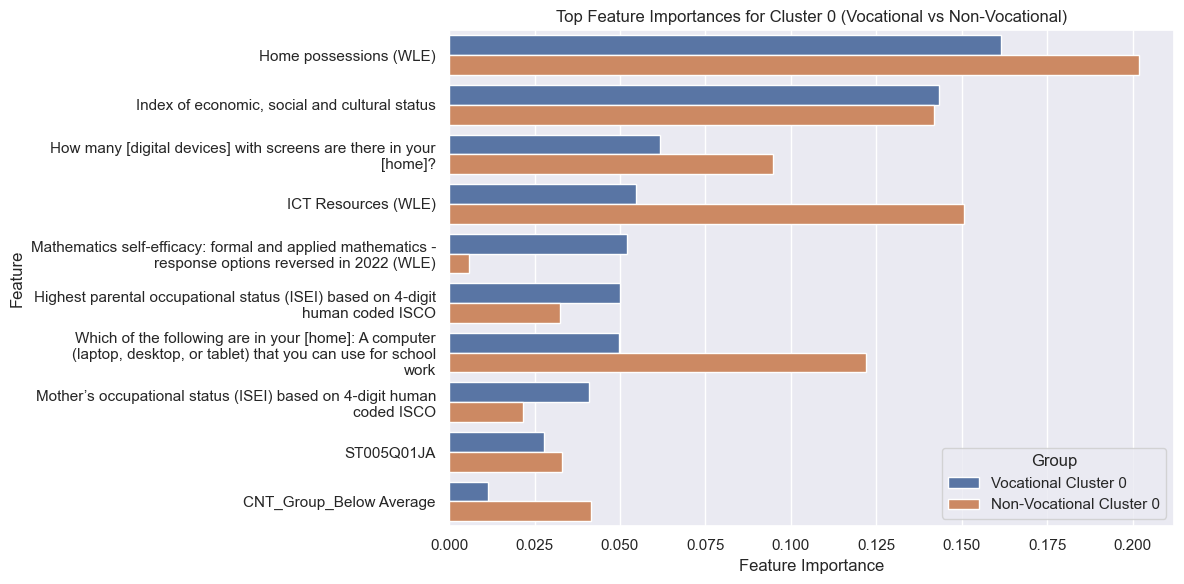

In [36]:
#Cluster 0
X_0_vocational = X_encoded_vocational.copy()
X_0_vocational["cluster_0"] = (X_0_vocational["kmeans"] == 0).astype(int)

X_vocational = X_0_vocational.drop(columns=["kmeans", "cluster_0"])
y_vocational = X_0_vocational["cluster_0"]

model_vocational = RandomForestClassifier(random_state=42)
model_vocational.fit(X_vocational, y_vocational)

importances_vocational = pd.Series(model_vocational.feature_importances_, index=X_vocational.columns)

X_0_non_vocational = X_encoded_non_vocational.copy()
X_0_non_vocational["cluster_0"] = (X_0_non_vocational["kmeans"] == 0).astype(int)

X_nonvocational = X_0_non_vocational.drop(columns=["kmeans", "cluster_0"])
y_nonvocational = X_0_non_vocational["cluster_0"]

model_nonvocational = RandomForestClassifier(random_state=42)
model_nonvocational.fit(X_nonvocational, y_nonvocational)

importances_nonvocational = pd.Series(
    model_nonvocational.feature_importances_, index=X_nonvocational.columns
)

importance_df = pd.DataFrame(
    {
        "Vocational Cluster 0": importances_vocational,
        "Non-Vocational Cluster 0": importances_nonvocational,
    }
)

top_features = (
    (importances_vocational.abs() + importances_nonvocational.abs())
    .sort_values(ascending=False)
    .head(10)
    .index
)
importance_df = importance_df.loc[top_features]

importance_df = importance_df.sort_values(by="Vocational Cluster 0", ascending=False)

plot_feature_importances(importance_df, cluster_id=0)

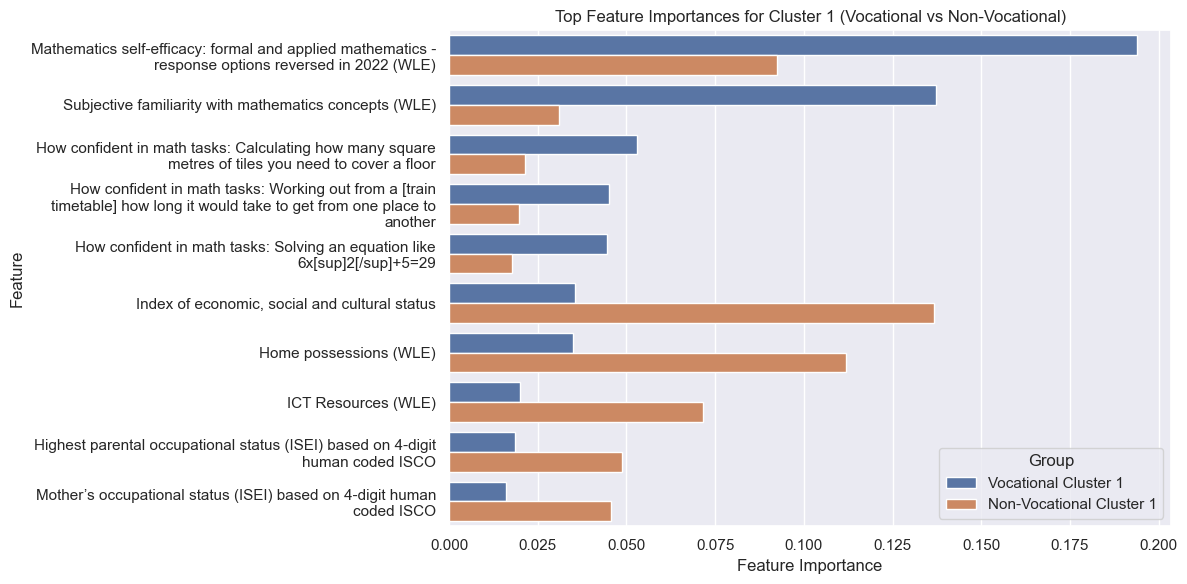

In [37]:
# Cluster 1

X_1_vocational = X_encoded_vocational.copy()
X_1_vocational["cluster_1"] = (X_1_vocational["kmeans"] == 1).astype(int)

X_vocational = X_1_vocational.drop(columns=["kmeans", "cluster_1"])
y_vocational = X_1_vocational["cluster_1"]

model_vocational = RandomForestClassifier(random_state=42)
model_vocational.fit(X_vocational, y_vocational)

importances_vocational = pd.Series(model_vocational.feature_importances_, index=X_vocational.columns)

X_1_non_vocational = X_encoded_non_vocational.copy()
X_1_non_vocational["cluster_1"] = (X_1_non_vocational["kmeans"] == 1).astype(int)

X_nonvocational = X_1_non_vocational.drop(columns=["kmeans", "cluster_1"])
y_nonvocational = X_1_non_vocational["cluster_1"]

model_nonvocational = RandomForestClassifier(random_state=42)
model_nonvocational.fit(X_nonvocational, y_nonvocational)

importances_nonvocational = pd.Series(
    model_nonvocational.feature_importances_, index=X_nonvocational.columns
)

importance_df = pd.DataFrame(
    {
        "Vocational Cluster 1": importances_vocational,
        "Non-Vocational Cluster 1": importances_nonvocational,
    }
)

top_features = (
    (importances_vocational.abs() + importances_nonvocational.abs())
    .sort_values(ascending=False)
    .head(10)
    .index
)
importance_df = importance_df.loc[top_features]

importance_df = importance_df.sort_values(by="Vocational Cluster 1", ascending=False)

plot_feature_importances(importance_df, cluster_id=1)

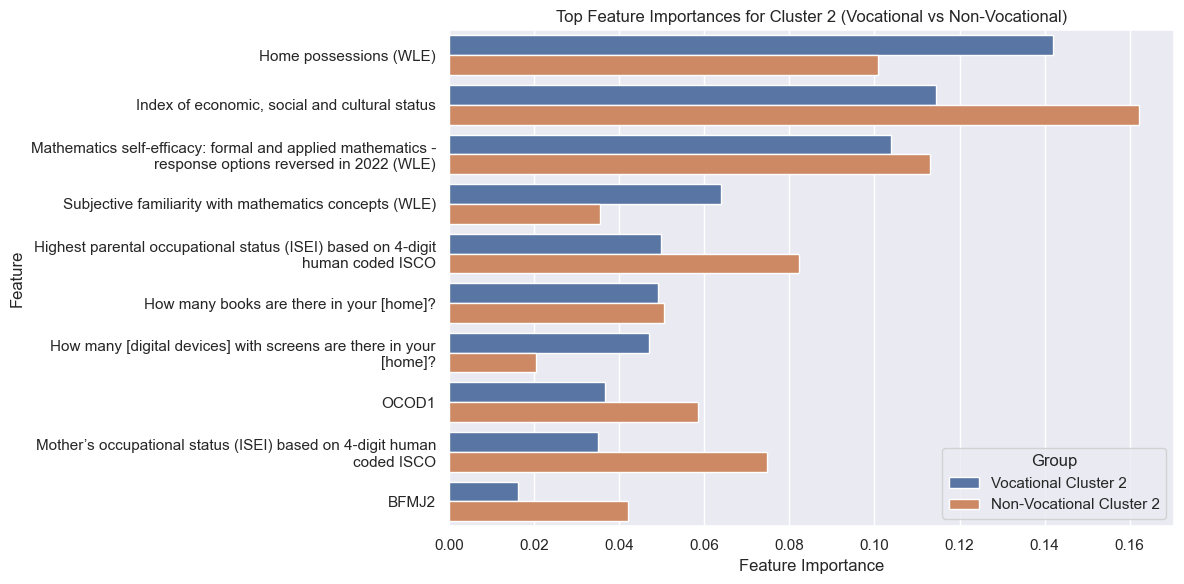

In [38]:
# Cluster 2
cluster = "cluster_2"

X_2_vocational = X_encoded_vocational.copy()
X_2_vocational[cluster] = (X_2_vocational["kmeans"] == 2).astype(int)

X_vocational = X_2_vocational.drop(columns=["kmeans", cluster])
y_vocational = X_2_vocational[cluster]

model_vocational = RandomForestClassifier(random_state=42)
model_vocational.fit(X_vocational, y_vocational)

importances_vocational = pd.Series(model_vocational.feature_importances_, index=X_vocational.columns)

X_2_non_vocational = X_encoded_non_vocational.copy()
X_2_non_vocational[cluster] = (X_2_non_vocational["kmeans"] == 2).astype(int)

X_nonvocational = X_2_non_vocational.drop(columns=["kmeans", cluster])
y_nonvocational = X_2_non_vocational[cluster]

model_nonvocational = RandomForestClassifier(random_state=42)
model_nonvocational.fit(X_nonvocational, y_nonvocational)

importances_nonvocational = pd.Series(
    model_nonvocational.feature_importances_, index=X_nonvocational.columns
)

importance_df = pd.DataFrame(
    {
        "Vocational Cluster 2": importances_vocational,
        "Non-Vocational Cluster 2": importances_nonvocational,
    }
)

top_features = (
    (importances_vocational.abs() + importances_nonvocational.abs())
    .sort_values(ascending=False)
    .head(10)
    .index
)

importance_df = importance_df.loc[top_features]
importance_df = importance_df.sort_values(by="Vocational Cluster 2", ascending=False)

plot_feature_importances(importance_df, cluster_id=2)

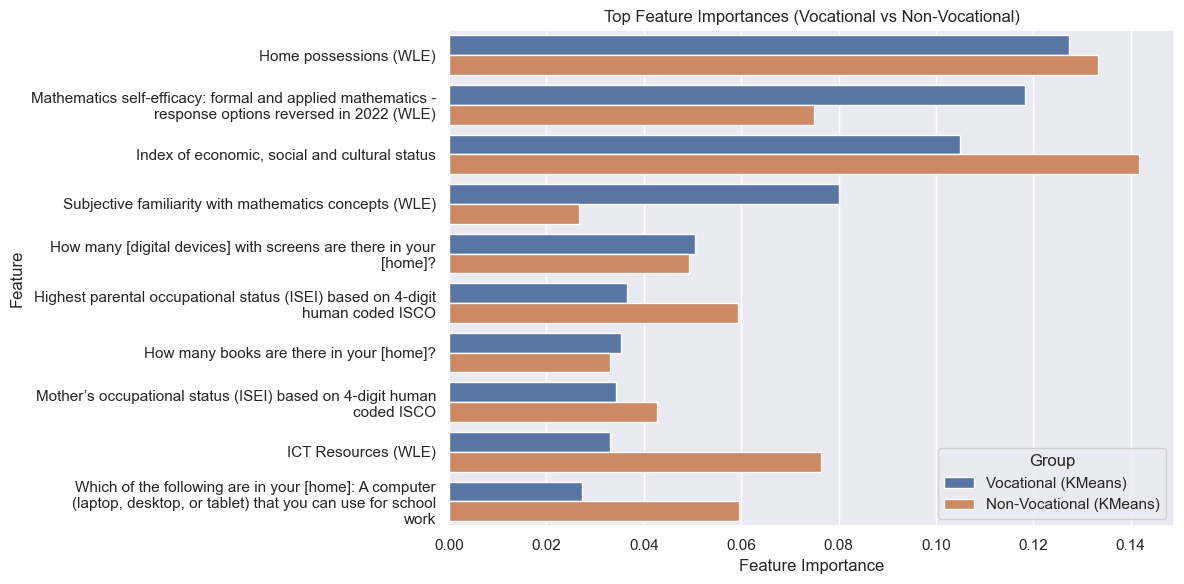

In [39]:
model_vocational = RandomForestClassifier(random_state=42)
model_vocational.fit(X_encoded_vocational.drop(columns=["kmeans"]), X_encoded_vocational["kmeans"])

importances_vocational = pd.Series(
    model_vocational.feature_importances_,
    index=X_encoded_vocational.drop(columns=["kmeans"]).columns,
)

model_nonvocational = RandomForestClassifier(random_state=42)
model_nonvocational.fit(X_encoded_non_vocational.drop(columns=["kmeans"]), X_encoded_non_vocational["kmeans"])

importances_nonvocational = pd.Series(
    model_nonvocational.feature_importances_,
    index=X_encoded_non_vocational.drop(columns=["kmeans"]).columns,
)

importance_all = pd.DataFrame({
    "Vocational (KMeans)": importances_vocational,
    "Non-Vocational (KMeans)": importances_nonvocational
})

top_features = (importances_vocational.abs() + importances_nonvocational.abs()).sort_values(ascending=False).head(10).index

importance_all = importance_all.loc[top_features]
importance_all = importance_all.sort_values(by="Vocational (KMeans)", ascending=False)

plot_feature_importances(importance_all, mapping=column_mapping)

In [20]:
silhouette_vocational = silhouette_score(
    X_encoded_vocational.drop(columns="kmeans"), kmeans_vocational.labels_
)
# silhouette_non_vocational = silhouette_score(
#     X_encoded_non_vocational.drop(columns="kmeans"), kmeans_non_vocational.labels_
# )

print(f"Silhouette Score (Vocational): {silhouette_vocational:.3f}")
# print(f"Silhouette Score (Non-Vocational): {silhouette_non_vocational:.3f}")

Silhouette Score (Vocational): 0.074
